In [2]:
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
from ci_adapt_utilities import *
import pickle
import os
from matplotlib import pyplot as plt
import ast
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd

# MIRACA color scheme

# Load default configuration and parameters
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

In [3]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [4]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())


In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = preprocess_assets(assets_path)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

122720 assets loaded.


In [6]:
rp_def = 'L'

In [7]:
area_of_interest = data_path / 'visualisation' / 'rhineland_palatinate.geojson'
area_of_interest = gpd.read_file(area_of_interest)
area_of_interest = area_of_interest.to_crs(epsg=4326)

In [13]:
# Extract the geometries of the stretches of disrupted rail track
disrupted_asset_ids=[]
for hazard_map, asset_dict in collect_output.items():
    rp = hazard_map.split('_RW_')[-1].split('_')[0]
    if rp != rp_def: continue

    overlay_assets=load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
    disrupted_asset_ids.extend(overlay_assets.asset.unique())

# for asset_id in disrupted_asset_ids:
#if the asset is a bridge or tunnel, drop the id from the disrupted_asset_ids list
disrupted_asset_ids_filt = [asset_id for asset_id in disrupted_asset_ids if assets.loc[asset_id, 'bridge'] == None and assets.loc[asset_id, 'tunnel'] == None]
    



In [8]:
print(f"{len(disrupted_asset_ids_filt)} assets are disrupted.")
print(f"{len(disrupted_asset_ids)} assets are disrupted, of which {len(disrupted_asset_ids_filt)} are not excluded bridges or tunnels.")

1404 assets are disrupted.
2088 assets are disrupted, of which 1404 are not excluded bridges or tunnels.


In [8]:
# haz_map_path=Path(r'C:\Data\Floods\Germany\raw_data\SzenarioSelten\DERP_RW_L.shp')
haz_map_path=Path(rf'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\hazard_maps_DERP\DERP_RW_{rp_def}_4326_valid_simplified_1m.geojson')  
haz_map=gpd.read_file(haz_map_path)
haz_map=gpd.GeoDataFrame(haz_map, geometry='geometry')

In [9]:
# Separate T_class into flood_area and depth_class
haz_map['flood_area']=[int(str(haz_map['T_class'][i])[0]) for i in range(len(haz_map))]
haz_map['depth_class']=[int(str(haz_map['T_class'][i])[1]) for i in range(len(haz_map))]


Zoom Level: 8
Requesting OSM tiles...
Plotting area of interest...
Plotting assets...
Finalizing plot...


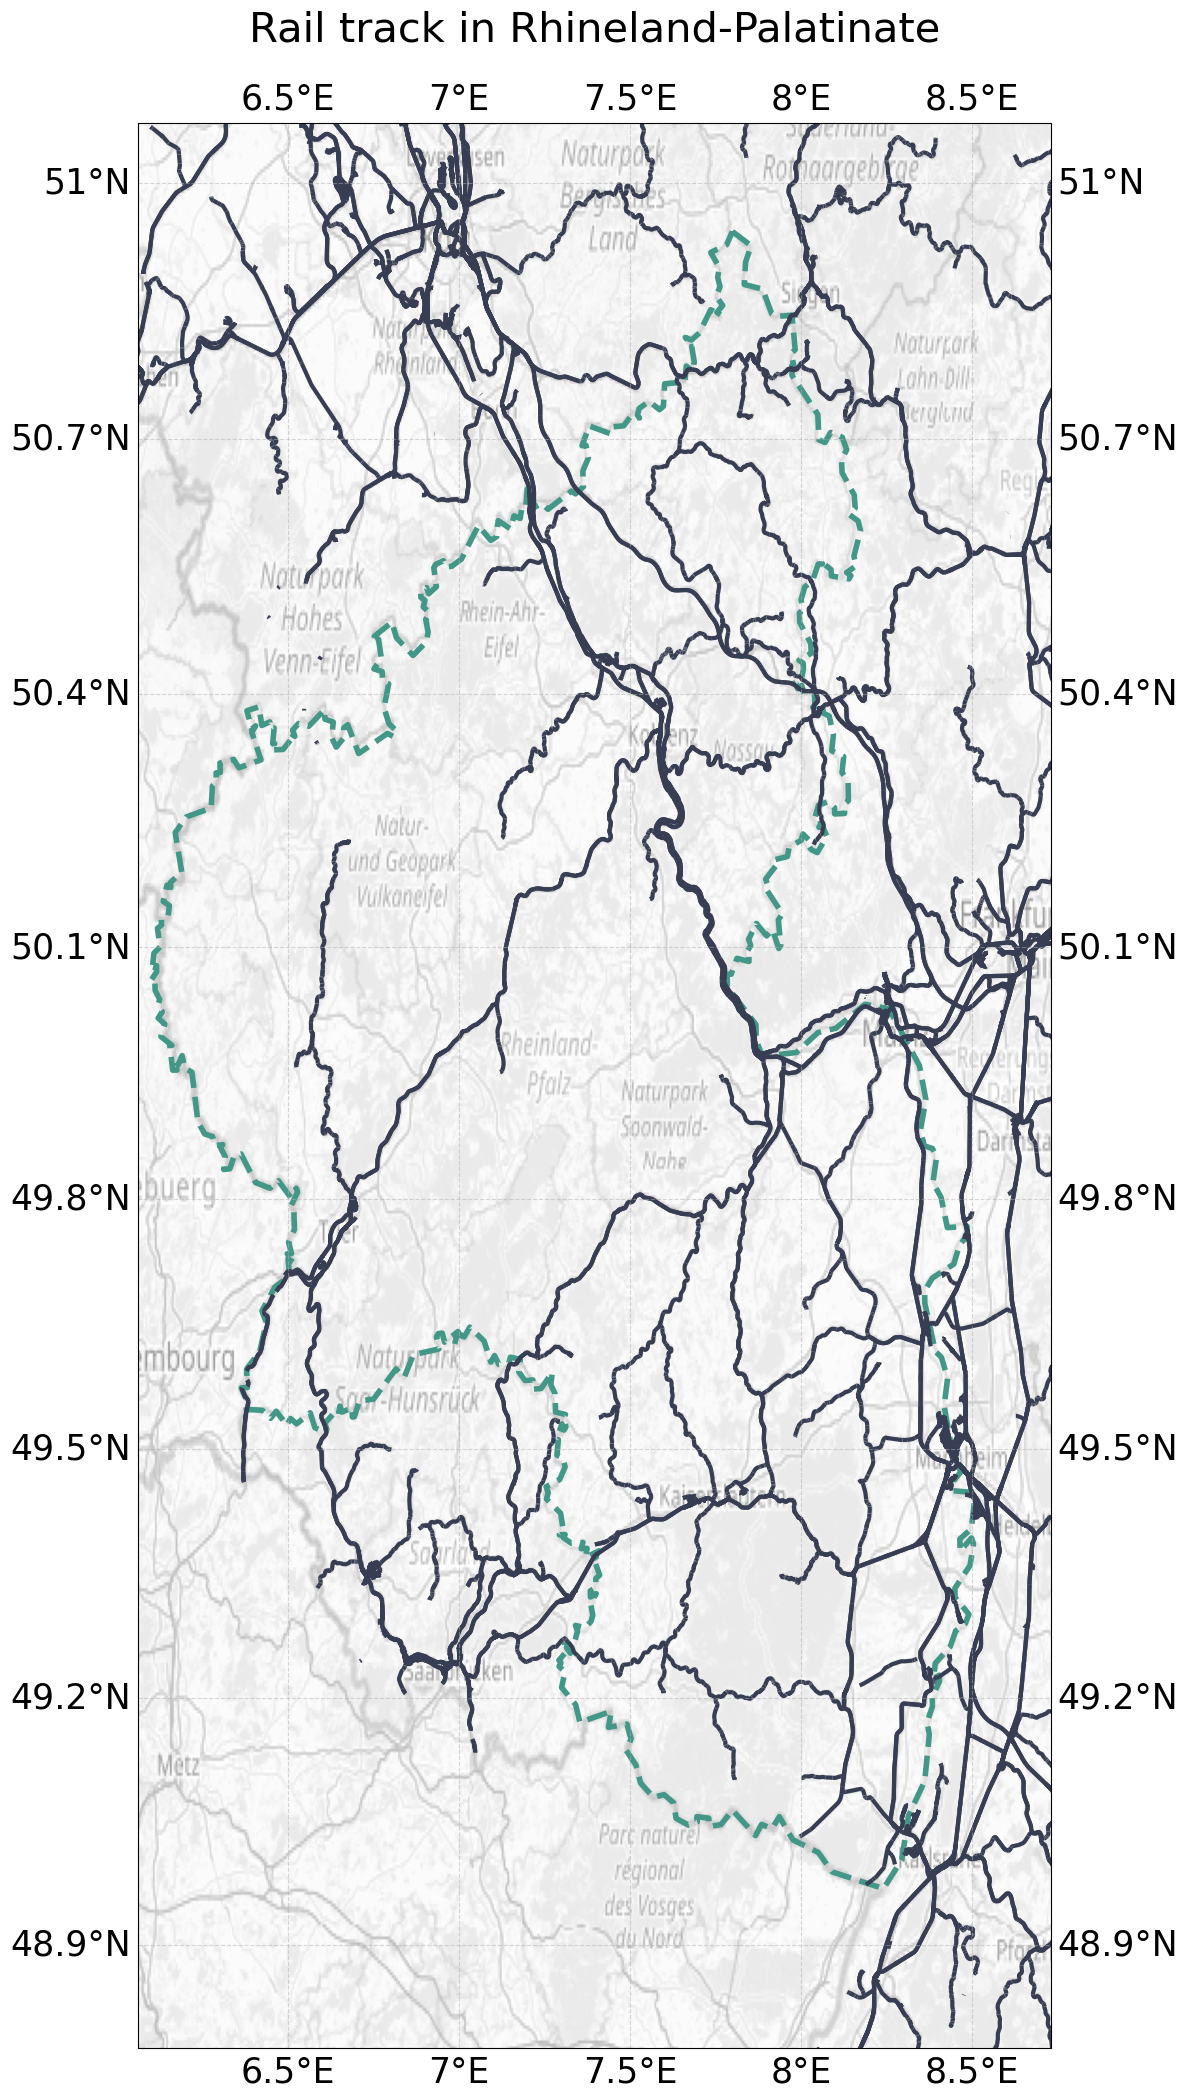

In [12]:
flood_gdf = haz_map
# helper function
def zoomlevel_from_deg(deg): #https://stackoverflow.com/questions/30052990/how-to-use-openstreetmap-background-on-matplotlib-basemap
    "Calculate OSM zoom level from a span in degrees.  Adjust +/-1 as desired"
    from numpy import log2, clip, floor
    zoomlevel = int(clip(floor(log2(360) - log2(delta)),0,20 ))
    return zoomlevel 

extent = haz_map.total_bounds

# Add clearance around the basin
clearance = 0.1  
lon_min, lat_min, lon_max, lat_max = extent
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

lon_min -= clearance * lon_range
lat_min -= clearance * lat_range
lon_max += clearance * lon_range
lat_max += clearance * lat_range

# Calculate aspect ratio
aspect_ratio = lon_range / lat_range

lon_i = lon_min + (lon_max - lon_min) / 2
lat_i = lat_min + (lat_max - lat_min) / 2
delta = 0.0016 # 0.0012 # 38 to 0.0002 degrees to avoid north pole
zoom = zoomlevel_from_deg(delta)-9 # 10 #  0-19 
print(f"Zoom Level: {zoom}")

# Create a plot with the OSM tiles
print('Requesting OSM tiles...')
# request_osm = cimgt.OSM()
request_osm = cimgt.OSM(desired_tile_form="L")

fig = plt.figure(figsize=(25 * aspect_ratio, 25))
ax = plt.axes(projection=request_osm.crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_image(request_osm, zoom, alpha=0.4, cmap='gray')  # Adjust zoom level as needed

# Plot the area of interest 
print('Plotting area of interest...')
area_of_interest.plot(ax=ax, facecolor='none', edgecolor=miraca_colors['green_900'], linewidth=4, linestyle='--', transform=ccrs.PlateCarree())

# # Plot the assets
print('Plotting assets...')
plot_assets=assets.drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets.plot(ax=ax, color=miraca_colors['grey_900'], linewidth=3, transform=ccrs.PlateCarree())

# # Plot the affected assets
plot_assets_affected = assets.iloc[disrupted_asset_ids_filt].drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets_affected.plot(ax=ax, color='red', linewidth=4, transform=ccrs.PlateCarree())


# # # # Plot the flood areas
print('Plotting flood areas...')
f_area_colors = {1:'blue', 3:'green'}
for f_area in tqdm(flood_gdf.flood_area.unique()):
    print('f_area: ',f_area)
    for f_depth in flood_gdf.depth_class.unique():
        print('->f_depth: ',f_depth)
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            subset_gdf.plot(ax=ax, facecolor=miraca_colors[color_key], edgecolor=miraca_colors[color_key], linewidth=0, alpha=0.8, transform=ccrs.PlateCarree())


# Add plot title
ax.set_title(f'Affected Rail Track in Rhineland-Palatinate, scenario {rp_def}', fontsize=30, pad=30)
# ax.set_title(f'Rail track in Rhineland-Palatinate', fontsize=30, pad=30)
            
print('Finalizing plot...')

# Add gridlines
ax.gridlines(draw_labels=True, xlabel_style={'size': 25}, ylabel_style={'size': 25}, alpha=0.5, linestyle='--')
plt.show()

Zoom Level: 8
Requesting OSM tiles...
Plotting area of interest...
Plotting flood areas...


  0%|          | 0/2 [00:00<?, ?it/s]

f_area:  1
->f_depth:  1
->f_depth:  2
->f_depth:  3
->f_depth:  4
->f_depth:  5


 50%|█████     | 1/2 [53:12<53:12, 3192.73s/it]

f_area:  3
->f_depth:  1
->f_depth:  2
->f_depth:  3
->f_depth:  4
->f_depth:  5


100%|██████████| 2/2 [55:36<00:00, 1668.14s/it]


Finalizing plot...


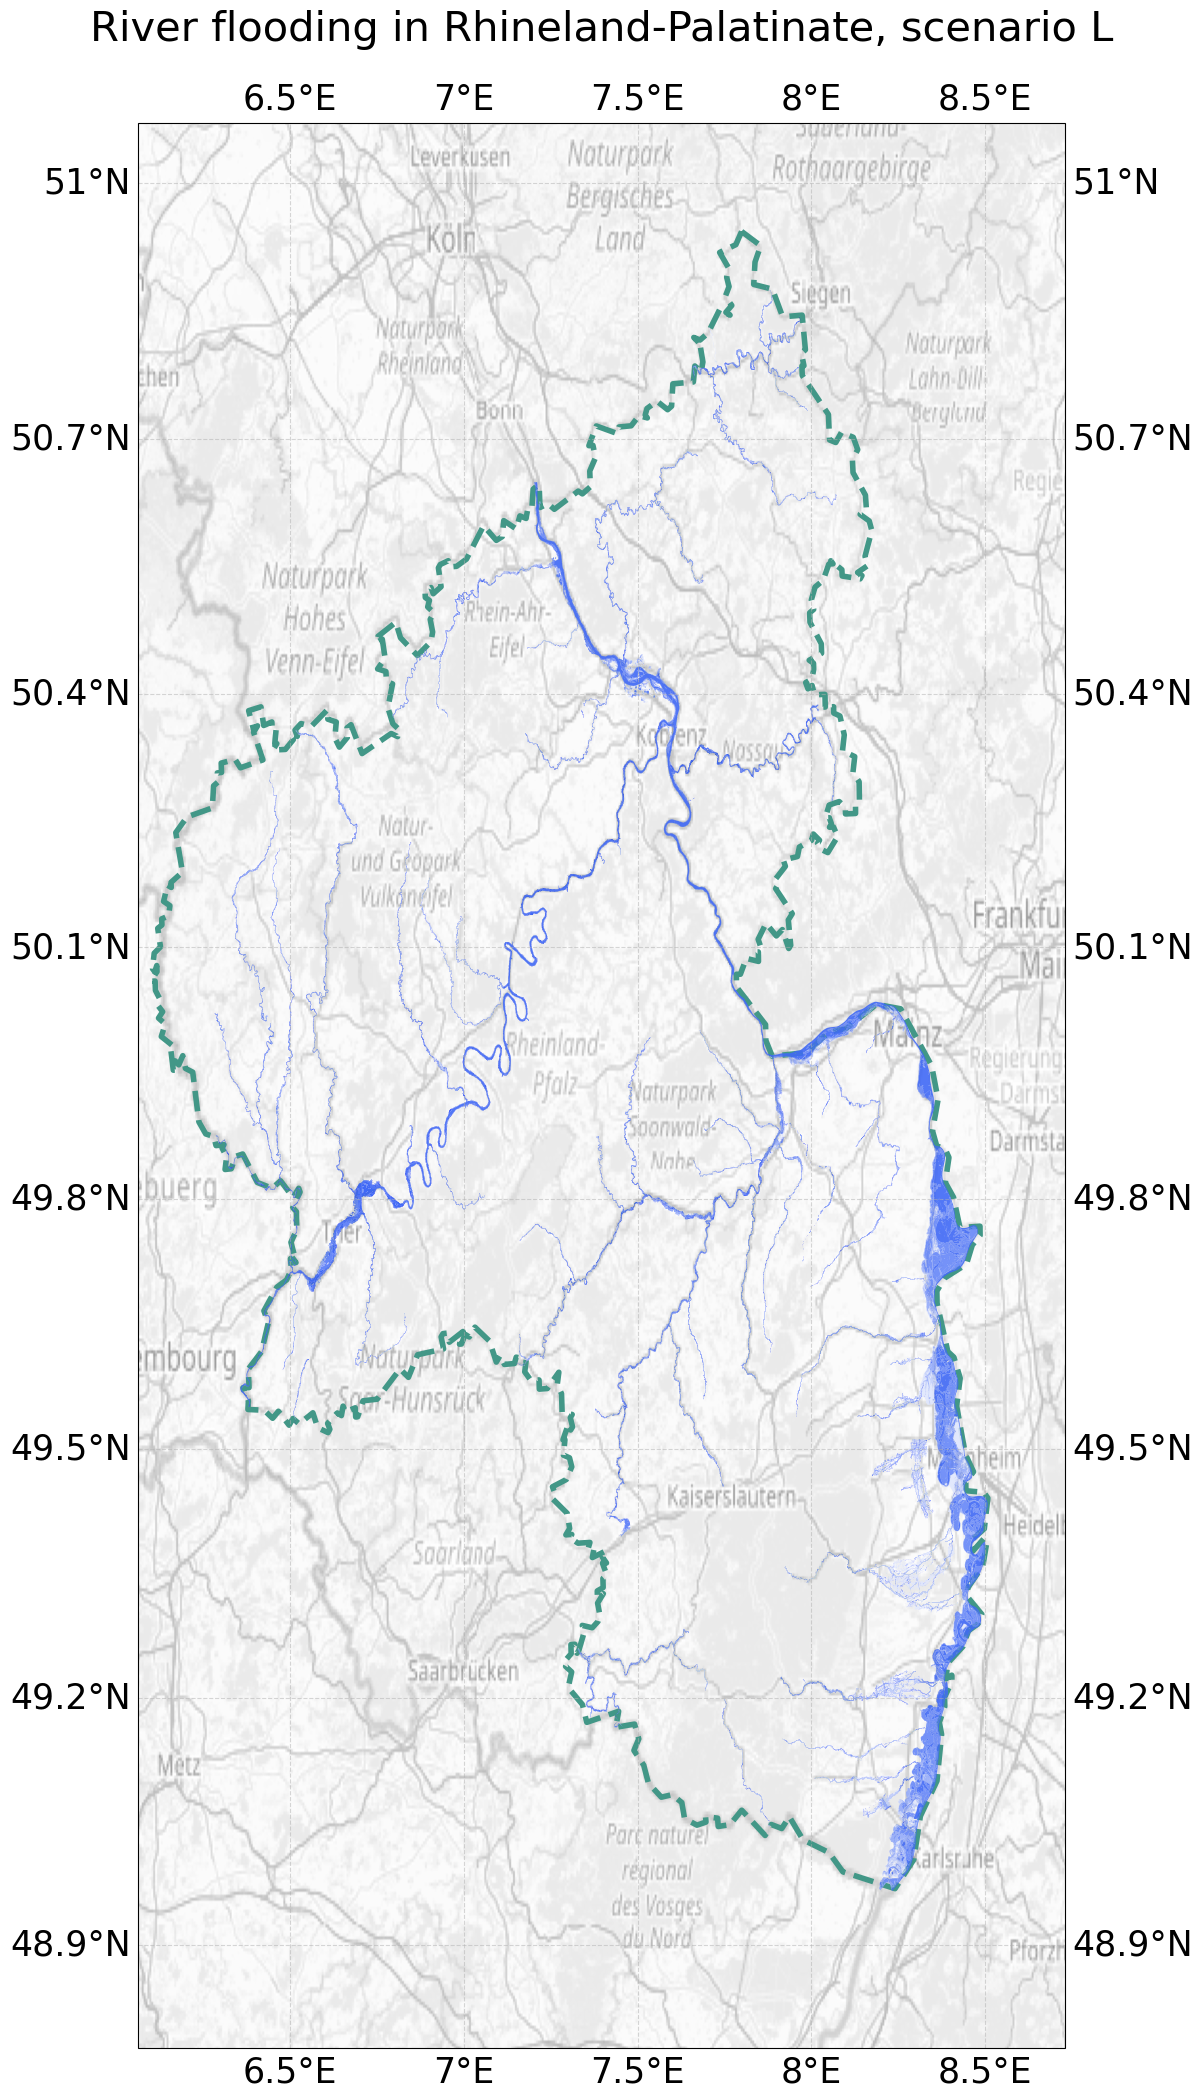

In [10]:
flood_gdf = haz_map
# helper function
def zoomlevel_from_deg(deg): #https://stackoverflow.com/questions/30052990/how-to-use-openstreetmap-background-on-matplotlib-basemap
    "Calculate OSM zoom level from a span in degrees.  Adjust +/-1 as desired"
    from numpy import log2, clip, floor
    zoomlevel = int(clip(floor(log2(360) - log2(delta)),0,20 ))
    return zoomlevel 

extent = haz_map.total_bounds

# Add clearance around the basin
clearance = 0.1  
lon_min, lat_min, lon_max, lat_max = extent
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

lon_min -= clearance * lon_range
lat_min -= clearance * lat_range
lon_max += clearance * lon_range
lat_max += clearance * lat_range

# Calculate aspect ratio
aspect_ratio = lon_range / lat_range

lon_i = lon_min + (lon_max - lon_min) / 2
lat_i = lat_min + (lat_max - lat_min) / 2
delta = 0.0016 # 0.0012 # 38 to 0.0002 degrees to avoid north pole
zoom = zoomlevel_from_deg(delta)-9 # 10 #  0-19 
print(f"Zoom Level: {zoom}")

# Create a plot with the OSM tiles
print('Requesting OSM tiles...')
# request_osm = cimgt.OSM()
request_osm = cimgt.OSM(desired_tile_form="L")

fig = plt.figure(figsize=(25 * aspect_ratio, 25))
ax = plt.axes(projection=request_osm.crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_image(request_osm, zoom, alpha=0.4, cmap='gray')  # Adjust zoom level as needed

# Plot the area of interest 
print('Plotting area of interest...')
area_of_interest.plot(ax=ax, facecolor='none', edgecolor=miraca_colors['green_900'], linewidth=4, linestyle='--', transform=ccrs.PlateCarree())

# # Plot the assets
# print('Plotting assets...')
# plot_assets=assets.drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
# plot_assets.plot(ax=ax, color=miraca_colors['grey_900'], linewidth=3, transform=ccrs.PlateCarree())

# Plot the affected assets
# plot_assets_affected = assets.iloc[disrupted_asset_ids_filt].drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
# plot_assets_affected.plot(ax=ax, color='red', linewidth=4, transform=ccrs.PlateCarree())


# # # Plot the flood areas
print('Plotting flood areas...')
f_area_colors = {1:'blue', 3: 'blue'}#'green'}
for f_area in tqdm(flood_gdf.flood_area.unique()):
    print('f_area: ',f_area)
    for f_depth in flood_gdf.depth_class.unique():
        print('->f_depth: ',f_depth)
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            subset_gdf.plot(ax=ax, facecolor=miraca_colors[color_key], edgecolor=miraca_colors[color_key], linewidth=0, alpha=0.9, transform=ccrs.PlateCarree())


# Add plot title
ax.set_title(f'River flooding in Rhineland-Palatinate, scenario {rp_def}', fontsize=30, pad=30)
            
print('Finalizing plot...')

# Add gridlines
ax.gridlines(draw_labels=True, xlabel_style={'size': 25}, ylabel_style={'size': 25}, alpha=0.5, linestyle='--')
plt.show()

In [12]:
# save the plot as svg
plot_path = data_path / 'output' / 'plots' / f'disrupted_rail_track_gray_{rp_def}.png'
fig.savefig(plot_path)